In [ ]:
## TRAINING SET : MERGED DATA , TESTING DATA: TCGA mRNA data, MODEL: Support Vector Machine

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import Lasso
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np

np.random.seed(7)

# Data Preprocessing

In [2]:
df_train = pd.read_csv("DS/mRNA_DS_preprocessed_training_data.csv")

In [3]:
df_test = pd.read_csv("DS/mRNA_TCGA_DS_test_data.csv")

In [4]:
df_train = df_train.T
df_test = df_test.T

In [5]:
#df_test = df_test[:-1]

In [6]:
#Transform the input data
df_train.rename(columns=df_train.iloc[0], inplace = True)
df_train.drop(df_train.index[0], inplace = True)
df_train=df_train.reset_index()

In [7]:
df_train=df_train.drop(['ACPP'], axis=1)

In [8]:
#Transform the input data
df_test.rename(columns=df_test.iloc[0], inplace = True)
df_test.drop(df_test.index[0], inplace = True)
df_test=df_test.reset_index()

In [9]:
metadata_test = pd.read_csv("DS/mRNA_TCGA_DS_col_data.csv")

In [10]:
df_test= df_test.merge(metadata_test, left_on="index", right_on= "Unnamed: 0")

In [16]:
df_test= df_test.rename(columns={"group_assignments": "title0"})

In [17]:
df_test['title0'] = df_test['title0'].replace('(?i)Control|mucosa|normal|healthy', 0, regex=True)


In [18]:
df_test['title0'] = df_test['title0'].replace('(?i)Tumor|Cancer|carcinoma', 1, regex=True)

In [19]:
df_test['title0'].value_counts()

title0
1    184
0     13
Name: count, dtype: int64

In [20]:
df_test = df_test[pd.to_numeric(df_test['title0'], errors='coerce').notnull()]#remove all non-numeric data from the column.

In [21]:
df_test= df_test.drop(['index', 'Unnamed: 0'], axis=1)

In [22]:
df_test= df_test.rename(columns={"title0": "index"})

In [23]:
# Select 13 rows of class 0
class_0 = df_test[df_test['index'] == 0].head(13)

# Select 13 rows of class 1
class_1 = df_test[df_test['index'] == 1].head(27)

# Concatenate the selected rows
df_test = pd.concat([class_0, class_1])

In [24]:
df_test['index'].value_counts()

index
1    27
0    13
Name: count, dtype: int64

In [25]:
X_test=df_test.drop("index",axis=1)
y_test=df_test['index']

In [26]:
metadata_train = pd.read_csv("DS/mRNA_DS_metadata_col_info.csv")

In [27]:
df_train= df_train.merge(metadata_train, left_on="index", right_on= "Unnamed: 0")

In [28]:
df_train['title0'] = df_train['title0'].replace('(?i)mucosa|normal|healthy', 0, regex=True)


In [29]:
df_train['title0'] = df_train['title0'].replace('(?i)Tumor|Cancer|carcinoma', 1, regex=True)

In [31]:
df_train = df_train[pd.to_numeric(df_train['title0'], errors='coerce').notnull()]#remove all non-numeric data from the column.

In [32]:
df_train= df_train.drop(['index', 'Unnamed: 0'], axis=1)

In [33]:
df_train= df_train.rename(columns={"title0": "index"})

In [35]:
df_train= df_train.apply(pd.to_numeric)

In [44]:
df_train['index'].value_counts()

index
0    111
1    108
Name: count, dtype: int64

In [45]:
X=df_train.drop("index",axis=1)
y=df_train['index']

In [46]:
X=X.astype('int')

In [47]:
y=y.astype('int')

# Feature Selection

In [48]:
# LASSO model:
lasso = Lasso(alpha=1)
# fitting the model:
lasso.fit(X, y)
# select all coefficients and the feature names
lasso_coefs = lasso.coef_
feature_names = X.columns

# collect the selected features:
selected_feature_indices = np.nonzero(lasso_coefs)[0]
selected_features = [feature_names[i] for i in selected_feature_indices]
X_selected = X.iloc[:, selected_feature_indices]

In [49]:
len(selected_features)

98

# Test train split

In [50]:
X_train = X_selected
y_train = y

In [51]:
y_test.value_counts(),y_train.value_counts()

(index
 1    27
 0    13
 Name: count, dtype: int64,
 index
 0    111
 1    108
 Name: count, dtype: int64)

# Cross validation

In [52]:
from sklearn.svm import SVC
# we can add class_weight='balanced' to add panalize mistake
svm_model = SVC(kernel = "linear", probability=True,random_state=47)

In [53]:

# Defining parameter range
param_grid = {
    'C': [0.0005,0.0001,0.001,0.1]
}

In [54]:

grid = GridSearchCV(svm_model, param_grid, refit=True, verbose=3)

In [55]:
# Fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ..........................C=0.0005;, score=0.955 total time=   0.0s
[CV 2/5] END ..........................C=0.0005;, score=0.932 total time=   0.0s
[CV 3/5] END ..........................C=0.0005;, score=0.955 total time=   0.0s
[CV 4/5] END ..........................C=0.0005;, score=0.932 total time=   0.0s
[CV 5/5] END ..........................C=0.0005;, score=0.884 total time=   0.0s
[CV 1/5] END ..........................C=0.0001;, score=0.932 total time=   0.0s
[CV 2/5] END ..........................C=0.0001;, score=0.795 total time=   0.0s
[CV 3/5] END ..........................C=0.0001;, score=0.955 total time=   0.0s
[CV 4/5] END ..........................C=0.0001;, score=0.886 total time=   0.0s
[CV 5/5] END ..........................C=0.0001;, score=0.860 total time=   0.0s
[CV 1/5] END ...........................C=0.001;, score=0.977 total time=   0.0s
[CV 2/5] END ...........................C=0.001;,

GridSearchCV(estimator=SVC(kernel='linear', probability=True, random_state=47),
             param_grid={'C': [0.0005, 0.0001, 0.001, 0.1]}, verbose=3)

# classification

In [56]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 0.001}
SVC(C=0.001, kernel='linear', probability=True, random_state=47)


In [57]:
# Select columns in df1 based on columns in df2
X_test = X_test.loc[:, X_train.columns]

In [58]:
X_test=X_test.dropna(axis=1)

In [59]:
model_svm = grid.best_estimator_
model_svm.fit(X_train,y_train)

SVC(C=0.001, kernel='linear', probability=True, random_state=47)

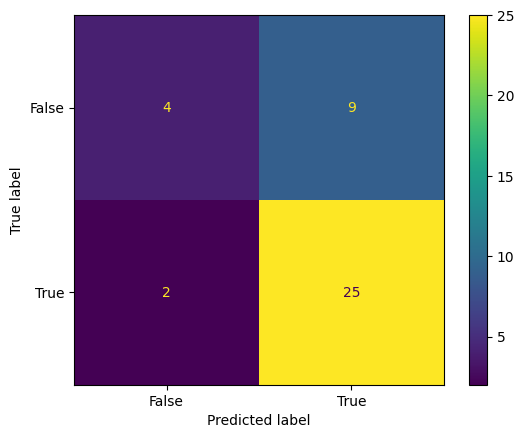

In [60]:
#######CONFUSION MATRIX ###########
from sklearn import metrics
y_test_pred_svm = model_svm.predict(X_test)
confusion_matrix_test = metrics.confusion_matrix(y_test, y_test_pred_svm)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_test, display_labels = [False, True])
cm_display.plot()
plt.show()

In [61]:
y_proba = model_svm.fit(X_train, y_train).predict_proba(X_test)[:,1]

In [62]:
total1=sum(sum(confusion_matrix_test))
#####from confusion matrix calculate accuracy
accuracy1=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
print('Specificity : ', specificity1)

Accuracy :  0.725
Sensitivity :  0.3076923076923077
Specificity :  0.9259259259259259


In [63]:
from sklearn.metrics import classification_report, confusion_matrix
grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.67      0.31      0.42        13
           1       0.74      0.93      0.82        27

    accuracy                           0.73        40
   macro avg       0.70      0.62      0.62        40
weighted avg       0.71      0.72      0.69        40



In [66]:
# for important features:
important_feat = model_svm.coef_[0]
#get indices of those important features
idx = important_feat.argsort(kind= "quicksort")
idx= idx[::-1][:50]

In [67]:
df1 = X_selected.T

In [68]:
top_met = df1.iloc[idx]

In [69]:
top_met.index

Index(['COL1A1', 'ECT2', 'COL7A1', 'IGF2BP2', 'COL5A2', 'NUSAP1', 'MCM2',
       'IGFBP3', 'FSCN1', 'LAMB3', 'RPN1', 'AGRN', 'EFNA1', 'LAMC2', 'TAPBP',
       'HSPBAP1', 'TGIF1', 'TYMP', 'ANO1', 'LCN2', 'UCHL1', 'AURKA', 'AIM2',
       'RUVBL1', 'TSPAN6', 'MYH10', 'DHRS2', 'IFI35', 'ERCC3', 'ENTPD6',
       'SLC2A1', 'PITX1', 'SSRP1', 'PCSK5', 'HSPD1', 'IL1RN', 'SERPINB13',
       'LYPD3', 'ACLY', 'SCNN1A', 'TMF1', 'GALNT1', 'SPRR3', 'ITPKC', 'STK24',
       'NT5C2', 'PTN', 'EMP1', 'TMPRSS11D', 'TST'],
      dtype='object')

In [70]:
X_selected.columns

Index(['ACLY', 'ACTG2', 'AGRN', 'AIM2', 'ALDH9A1', 'ALOX12', 'ANO1', 'AQP3',
       'ATP6V1D', 'AURKA', 'CCNG2', 'CES2', 'CFD', 'CH25H', 'CLIC3', 'COL1A1',
       'COL5A2', 'COL7A1', 'CRABP2', 'CRCT1', 'CRISP3', 'CRNN', 'CYP4B1',
       'DHRS1', 'DHRS2', 'DUOX1', 'DUSP5', 'ECM1', 'ECT2', 'EFNA1', 'EMP1',
       'ENTPD6', 'ERCC3', 'FLG', 'FSCN1', 'GALE', 'GALNT1', 'GPX3', 'HOPX',
       'HSPB8', 'HSPBAP1', 'HSPD1', 'ID4', 'IFI35', 'IGF2BP2', 'IGFBP3',
       'IL1RN', 'INPP1', 'ITPKC', 'KANK1', 'KLK13', 'KRT4', 'LAMB3', 'LAMC2',
       'LCN2', 'LYPD3', 'MAL', 'MCM2', 'MUC1', 'MYH10', 'NDRG2', 'NT5C2',
       'NUSAP1', 'PCSK5', 'PHLDA1', 'PITX1', 'PPP1R3C', 'PTN', 'RAB11FIP1',
       'RANBP9', 'RHCG', 'RND3', 'RPN1', 'RUVBL1', 'SCNN1A', 'SERPINB13',
       'SERPINB2', 'SIM2', 'SLC2A1', 'SLK', 'SPRR3', 'SSRP1', 'STK24',
       'SYNPO2L', 'TAPBP', 'TFAP2B', 'TGIF1', 'TIAM1', 'TJP1', 'TMF1',
       'TMPRSS11D', 'TMPRSS11E', 'TSPAN6', 'TST', 'TYMP', 'UCHL1', 'ZBTB16',
       'ZNF185'],
      

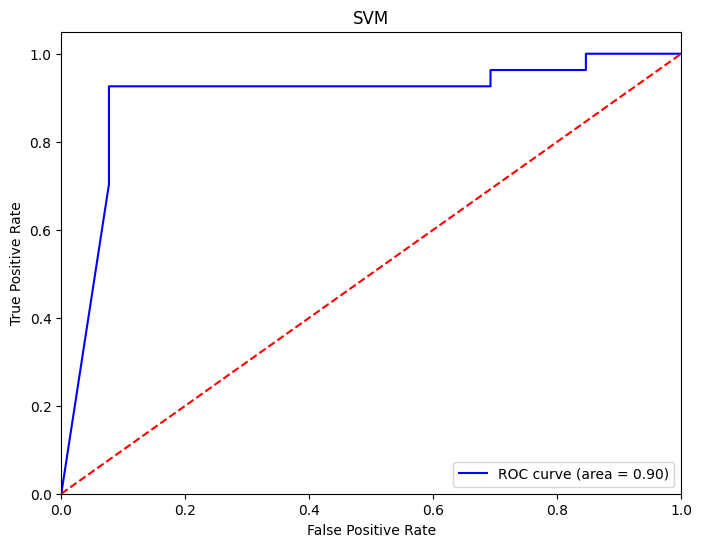

In [72]:
from sklearn.metrics import roc_curve, auc
# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM')
plt.legend(loc='lower right')
plt.show()